## Multi-class Classification

In [66]:
from IPython import display
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import sys, os
import matplotlib.pyplot as plt

batch_size = 256
sys.path.append(os.getcwd()+'/data')
mypath = sys.path.pop()

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root=mypath, train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root=mypath, train=False, transform=trans, download=True)

In [67]:
len(mnist_train), len(mnist_test), type(mnist_train), type(mnist_train[0]), len(mnist_train[0])

(60000, 10000, torchvision.datasets.mnist.FashionMNIST, tuple, 2)

In [68]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

(<matplotlib.image.AxesImage at 0x135d8adc0>, tensor(9))

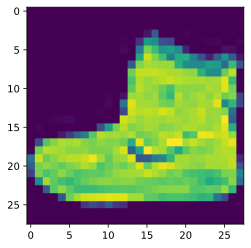

In [69]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
plt.imshow(X[0][0]), y[0]

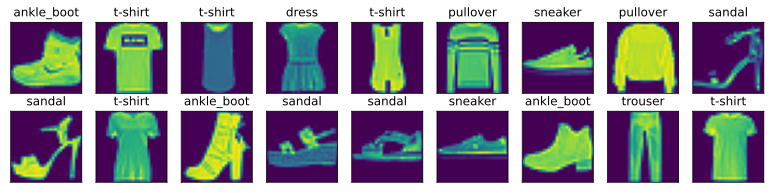

In [70]:
#visualization 
num_cols = 9
num_rows = 2
scale = 1.5
imgs = X.reshape(18, 28, 28) #note: check the shape of X 
titles = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
'sneaker', 'bag', 'ankle_boot']

figsize = (num_cols * scale, num_rows * scale)
_, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
    # Tensor Image
        ax.imshow(img.numpy())
    else:
        # PIL Image
        ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
        ax.set_title(titles[y[i].item()])

In [208]:
# util functions
import time
class Timer: #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """Start the timer."""
        self.tik = time.time()
    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)
    def sum(self):
        """Return the sum of time."""
        return sum(self.times)
    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here
    


def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())  # metric.add(accuracy(net(X), y), len(y))

    return metric[0] / metric[1]

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
lr = 0.1
def updater(batch_size):
    return sgd([W, b], lr, batch_size)


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


### * Build model from scratch

In [209]:
# initialize weights
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

train_iter = data.DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size=256, shuffle=True, num_workers=4)


# define model
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# define loss function
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [210]:
# for X, y in train_iter:
    
#     # Compute gradients and update parameters
#     y_hat = net(X)
print(y_hat.shape)

torch.Size([96, 10])


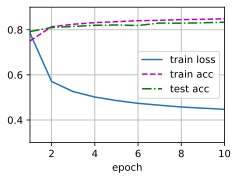

In [211]:
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                    legend=['train loss', 'train acc', 'test acc'])
num_epochs = 10

for epoch in range(num_epochs):
    
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = cross_entropy(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):   # False 
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])    # input is batch size 
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
            
            
    train_metrics = metric[0] / metric[2], metric[1] / metric[2]
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
train_loss, train_acc = train_metrics
# assert train_loss < 0.5, train_loss
# assert train_acc <= 1 and train_acc > 0.7, train_acc
# assert test_acc <= 1 and test_acc > 0.7, test_acc

In [212]:
# notes ！！！！ 
y_in = torch.rand(size=[2,3])
net = nn.Softmax(dim=1)
output = net(y_in)
output 

tensor([[0.3882, 0.3977, 0.2141],
        [0.4375, 0.1747, 0.3878]])

In [213]:
def crossEntropy(y_true, logits):
    c = -torch.log(logits.gather(1, y_true.reshape(-1, 1)))
    return torch.sum(c)

logits = output
y_true = torch.LongTensor([2, 1])
y_true.reshape(-1, 1)

tensor([[2],
        [1]])

In [214]:
logits.gather(1, y_true.reshape(-1, 1))

tensor([[0.2141],
        [0.1747]])

In [215]:
-torch.log(logits.gather(1, y_true.reshape(-1, 1)))

tensor([[1.5413],
        [1.7447]])

In [216]:
crossEntropy(y_true, logits)

tensor(3.2860)

In [220]:
trans = transforms.ToTensor()

mnist_test = torchvision.datasets.FashionMNIST(root=mypath, train=False, transform=trans, download=True)
test_iter = data.DataLoader(mnist_test, batch_size=128, shuffle=True, num_workers=4)

In [221]:
# next(iter(test_iter)) ## some sample data is very sparse!!!!

In [222]:
# Prediction: 
def predict_ch3(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

ValueError: only one element tensors can be converted to Python scalars

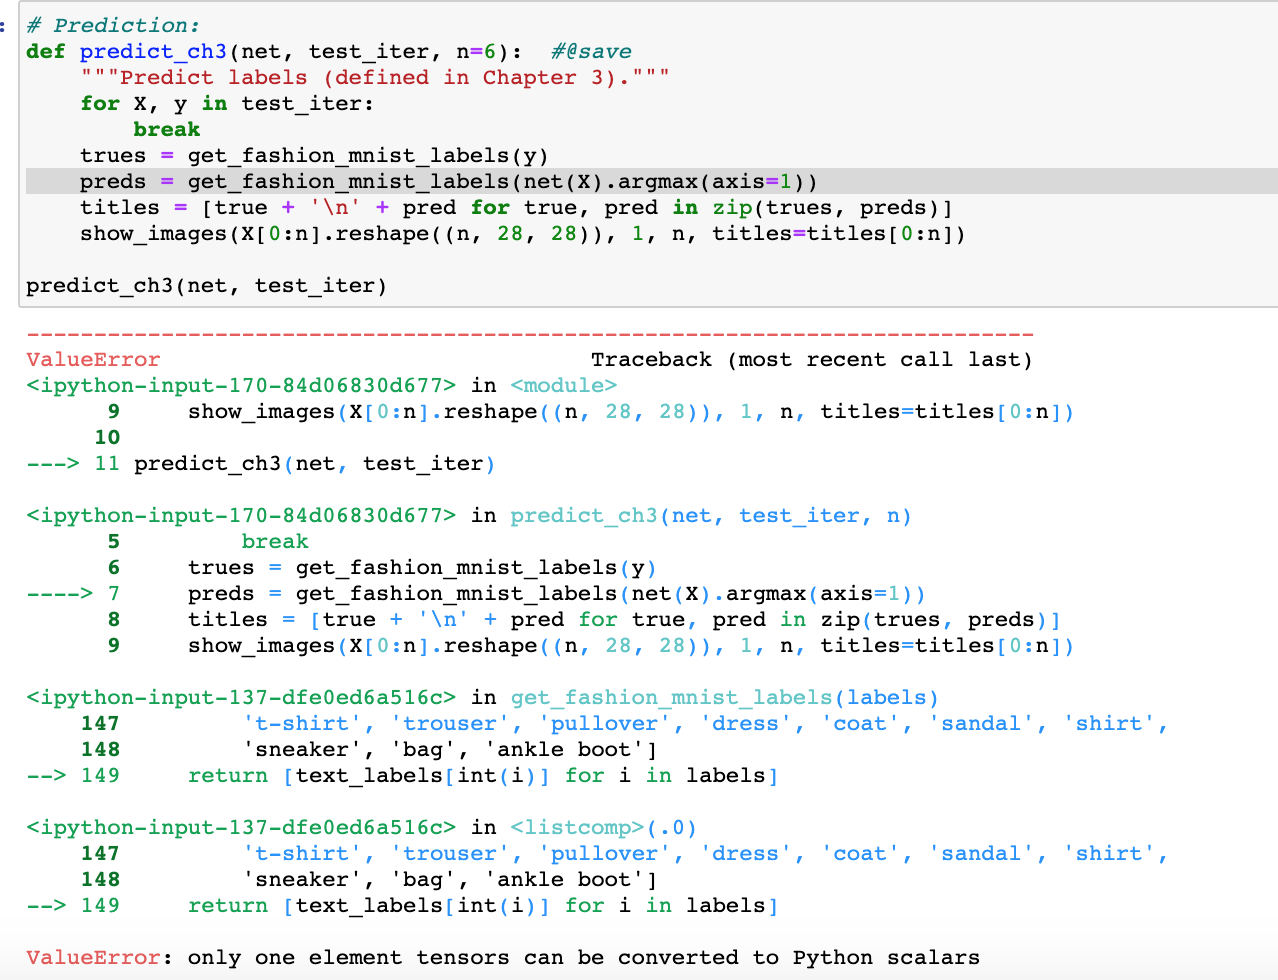

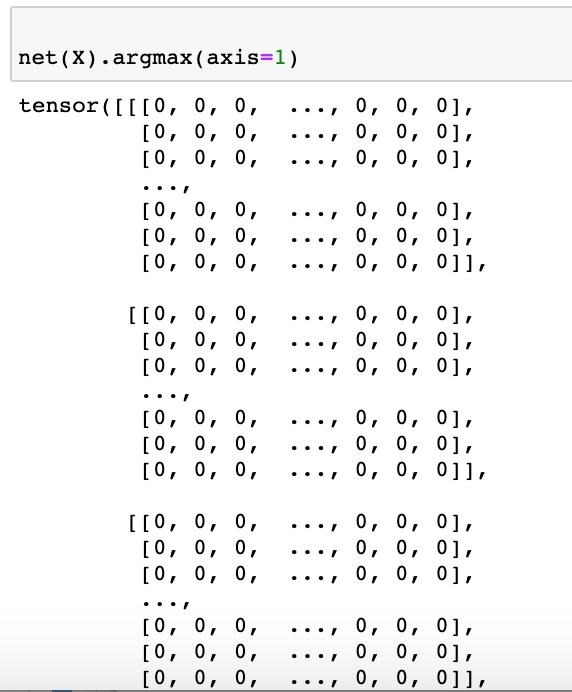

## WHY??  Overflow or underflow 

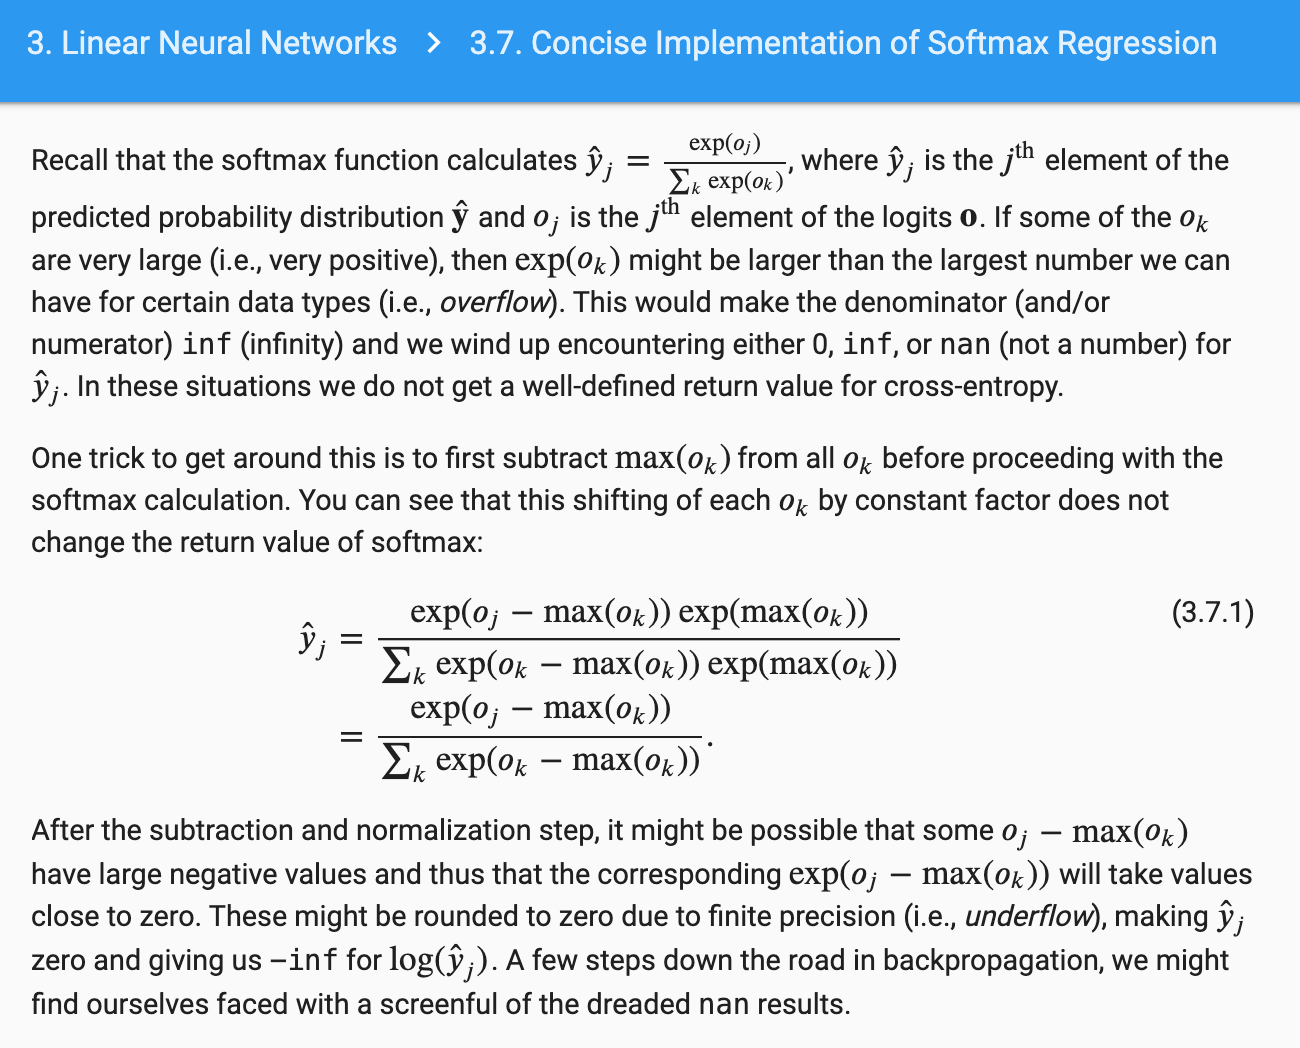

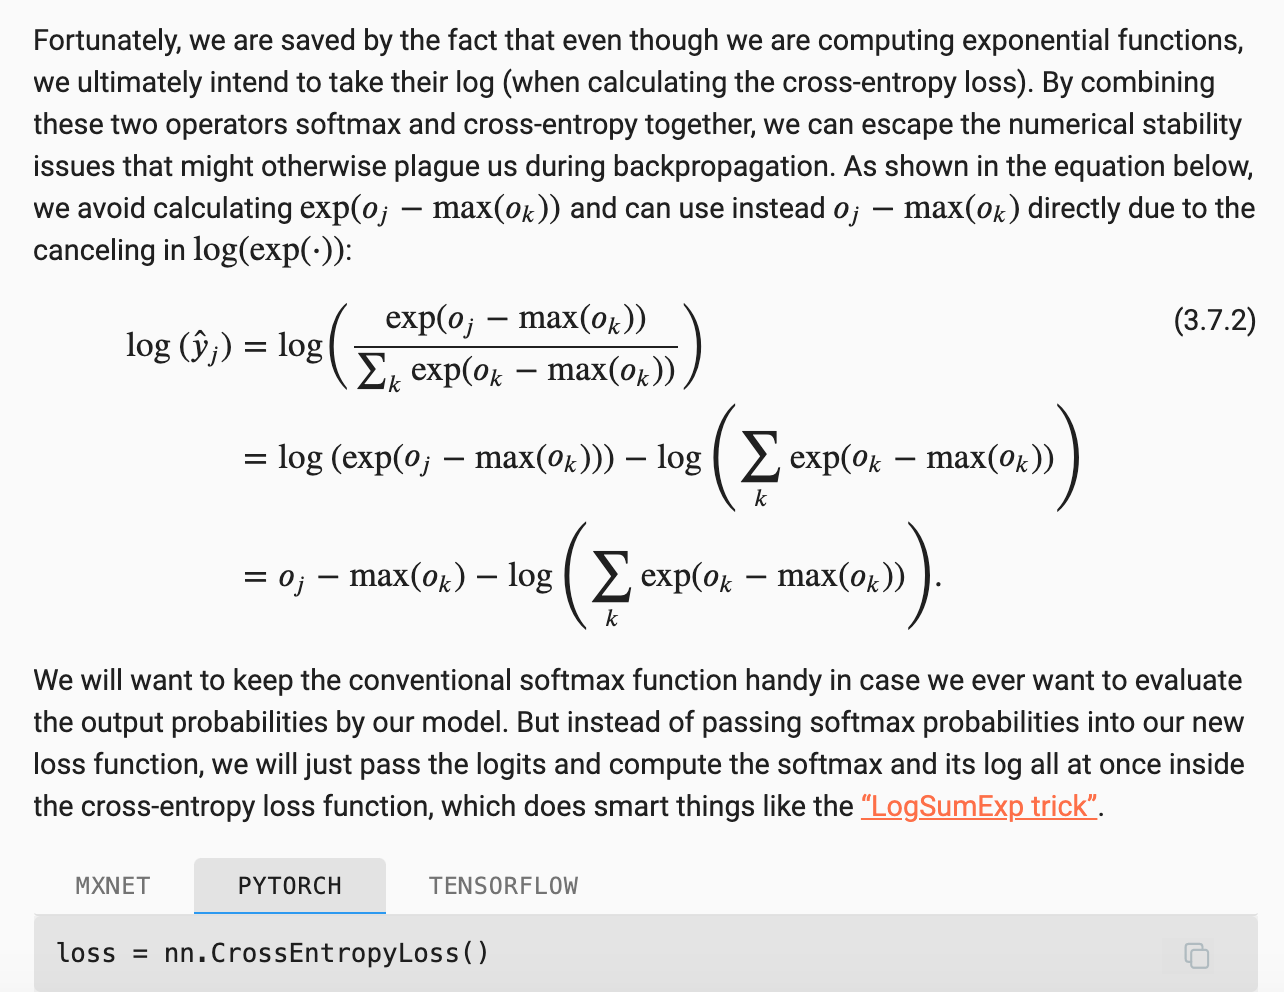

### * Build concise model

In [133]:
train_iter = data.DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size=256, shuffle=True, num_workers=4)
from torch import nn

# Note: find high-level API from torch.nn and torch.optim !! 
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
print(net)


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);
print(net)


loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


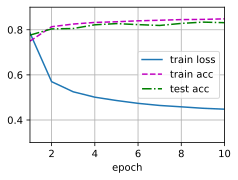

In [134]:
num_epochs = 10

animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                    legend=['train loss', 'train acc', 'test acc'])

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, trainer)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
    
train_loss, train_acc = train_metrics
assert train_loss < 0.5, train_loss
assert train_acc <= 1 and train_acc > 0.7, train_acc
assert test_acc <= 1 and test_acc > 0.7, test_acc

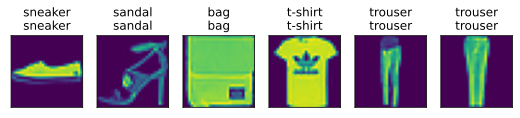

In [135]:
predict_ch3(net, test_iter)